In [1]:
from dask.distributed import Client
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
client

<Client: 'tcp://203.247.189.224:44420' processes=5 threads=90, memory=419.10 GiB>

In [2]:
def simpledrawbox(pt1,pt2,color='black',linewidth=2,shiftx=0, linestyle='--'):
   #Draws an area box.
   transform=ccrs.PlateCarree()
  
   xx1 = pt1[0] ; yy1 = pt1[1]
   xx2 = pt2[0] ; yy2 = pt2[1]
 
   xx1 = xx1-shiftx
   xx2 = xx2-shiftx
 
   plt.plot([xx1,xx2],[yy1,yy1], color=color, linewidth=linewidth,transform=transform)
   plt.plot([xx1,xx2],[yy2,yy2], color=color, linewidth=linewidth,transform=transform)
   plt.plot([xx1,xx1],[yy1,yy2], color=color, linewidth=linewidth,transform=transform)
   plt.plot([xx2,xx2],[yy1,yy2], color=color, linewidth=linewidth,transform=transform)
   return None

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import matplotlib.patches as patches
from scipy import stats
import cmocean
import glob
from cmcrameri import cm
from tqdm.notebook import tqdm_notebook

In [7]:
import warnings
warnings.simplefilter(action='ignore')

  0%|          | 0/25 [00:00<?, ?it/s]

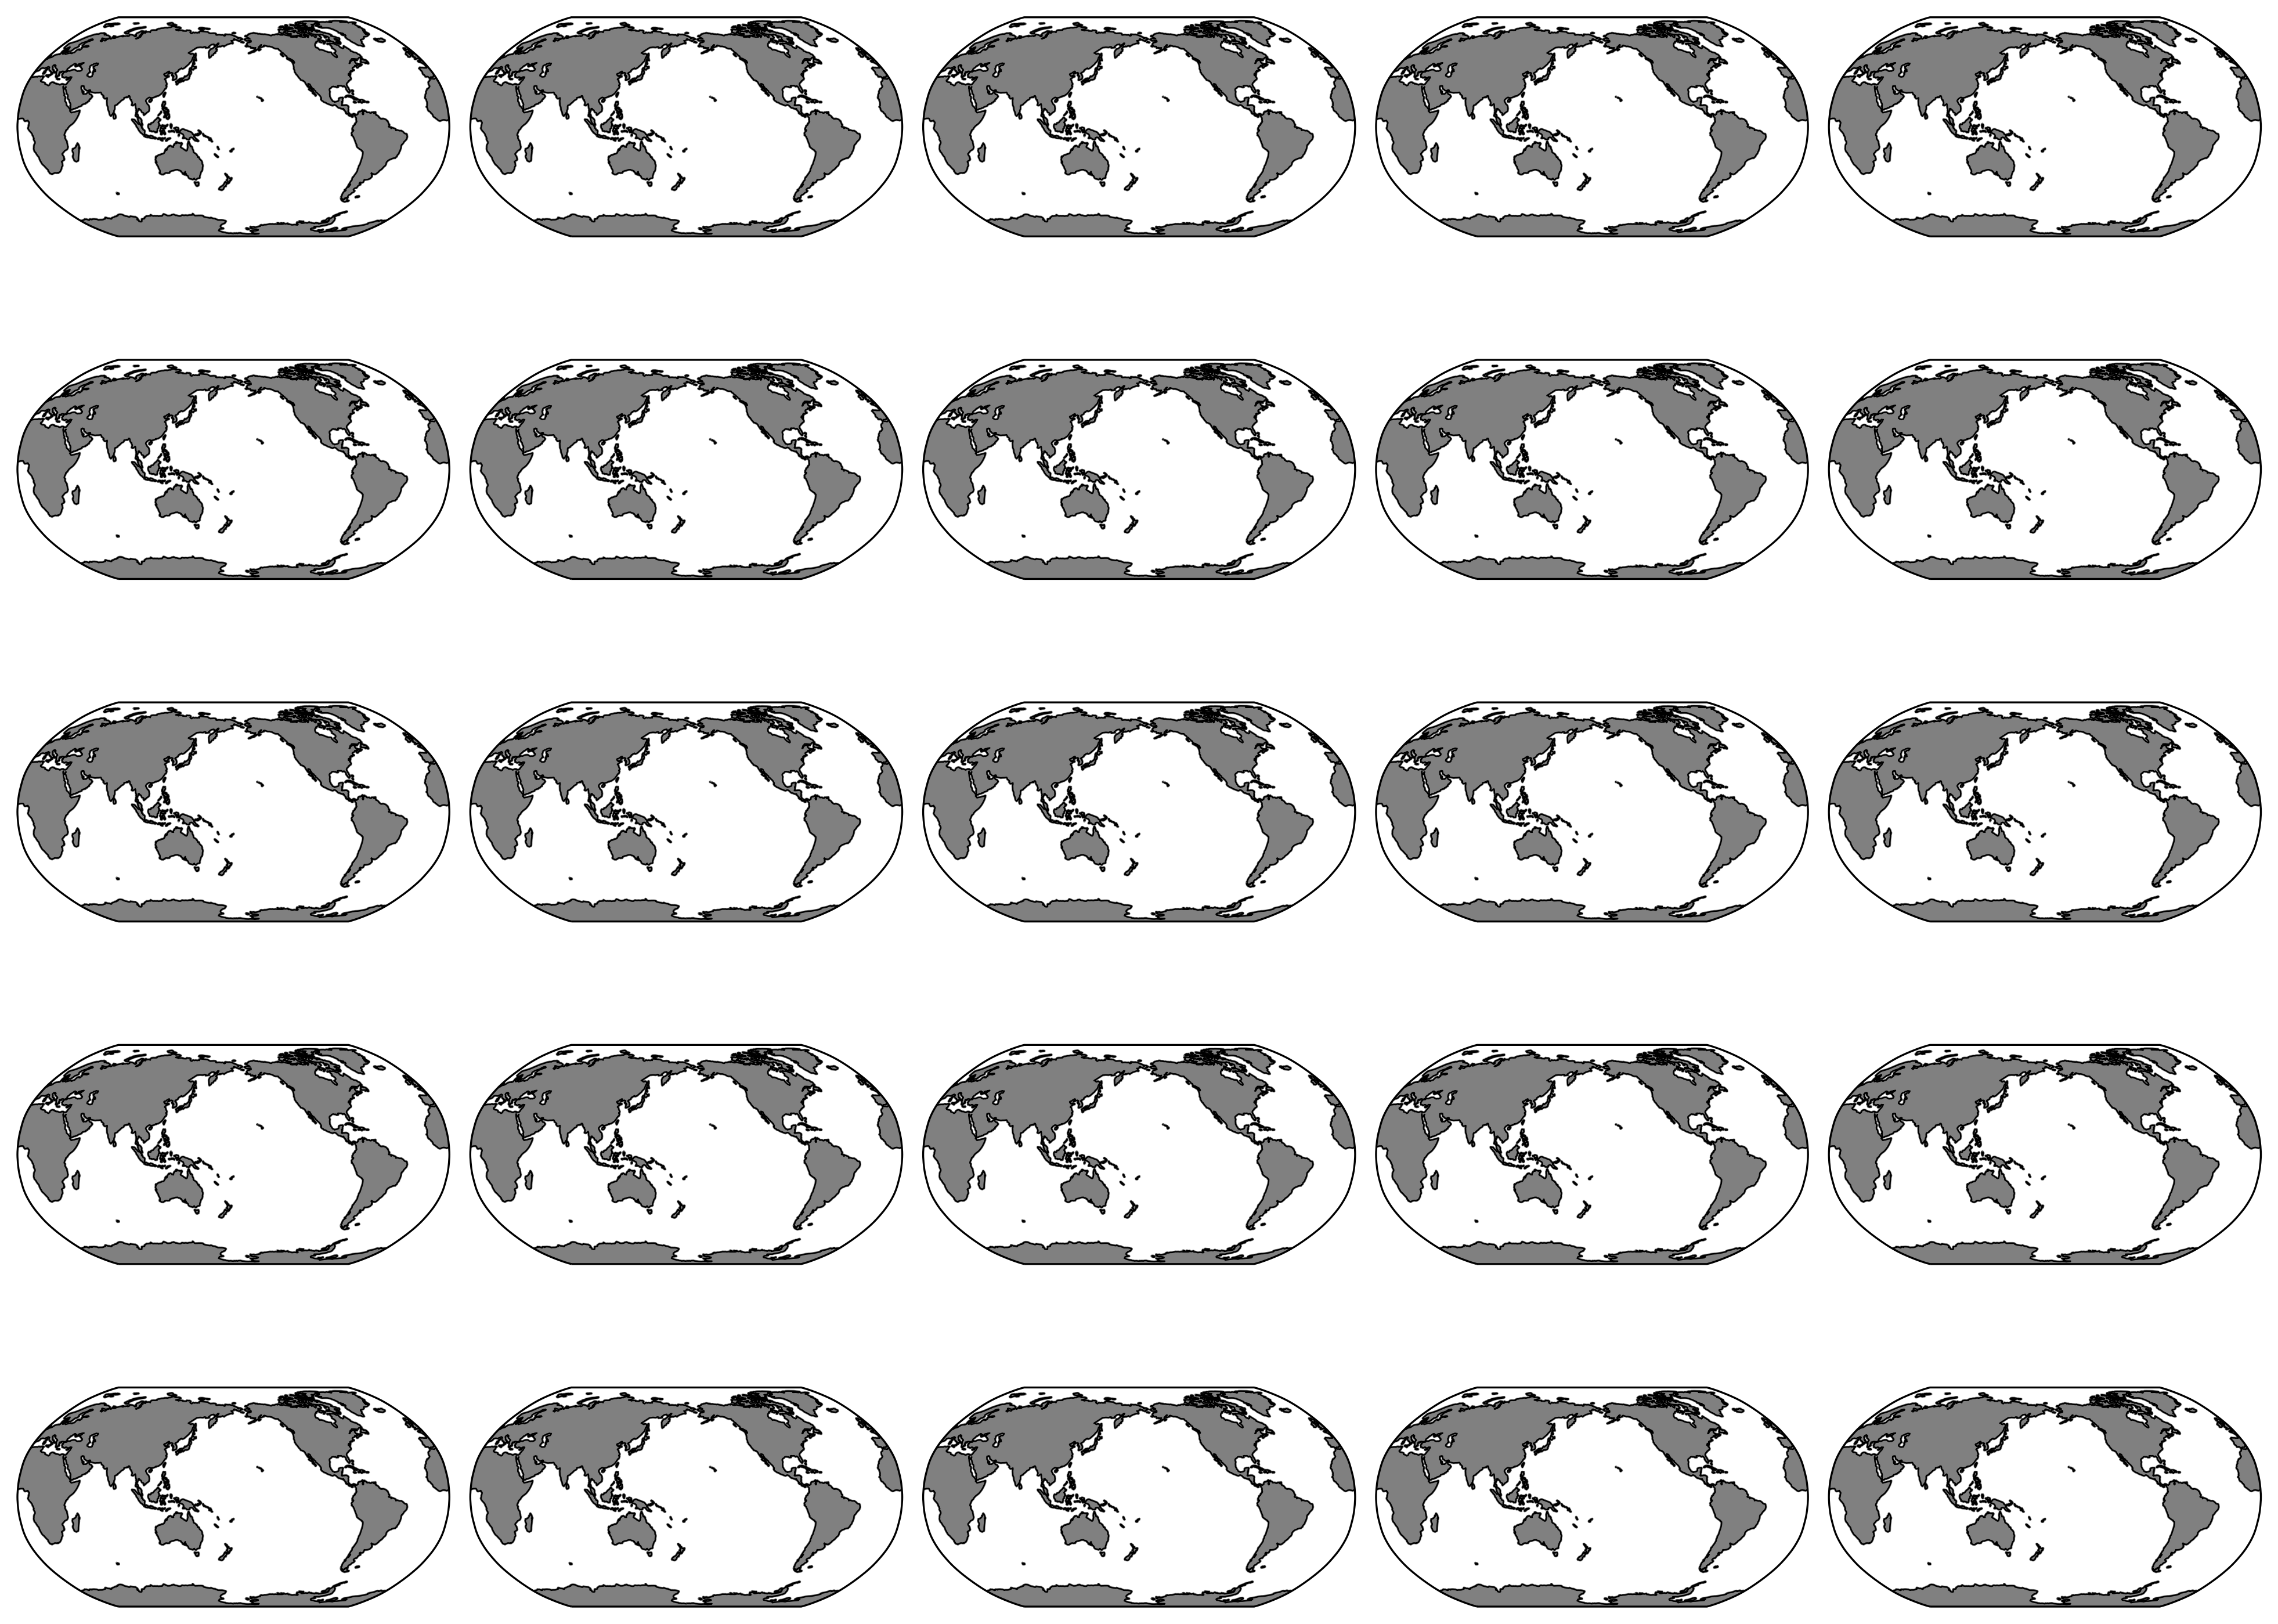

In [12]:
plt.rcParams.update({'font.size': 8})
fig,ax = plt.subplots(5,5,figsize=(17.5, 18), dpi=300, facecolor='w', edgecolor='k',subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

for i,a in enumerate(tqdm_notebook(ax.flat)) :
    #clabel=('%s'%units[i])
    #cbar_kwargs={'orientation':'horizontal','pad':0.01,'shrink':0.7, 'label':clabel}
    #fields[i].plot.contourf(ax=a,transform=ccrs.PlateCarree(),levels=levels[i],cbar_kwargs=cbar_kwargs,cmap=cbar[i], extend='both')
    a.add_feature(cfeature.LAND,color='grey')
    a.coastlines(linewidth=0.6,color='black')
    a.set_global() 

plt.tight_layout(rect=[0.15, 0.35, 0.90, 0.97])

In [5]:
import warnings
warnings.simplefilter(action='ignore')

In [6]:
VAR=['U', 'V', 'PSL', 'PRECT']

scenarios=('HISTsmbb','SSP370smbb','SSP370smbbext')
members=('1011.001','1031.002','1051.003','1071.004','1091.005',
         '1111.006','1131.007','1151.008','1171.009','1191.010')

ensembles = [ens for ens in range(len(members))]

In [7]:
exceptcv=['time','lon','lat','lev',*VAR]
def process_coords(ds, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
    ds=ds.sel(lon=slice(30,120), lat=slice(-40,45)).isel(lev=25)
    if drop:
        return ds.drop(coord_vars)
    else:
        return ds.set_coords(coord_vars)

In [10]:
time='month_1'

file_list=[]
for var in VAR :
    ens_files=[]
    for member in members :
        files=[]    
        for scenario in scenarios :
            comp,model='atm','cam.h0'
            #if var=='NBP' or var=='NPP': comp,model='lnd','clm2.h0'
                
            if scenario != 'SSP370smbbext':
                
                in_dir = '/proj/jedwards/archive/b.e21.B'+scenario+'.f09_g17.LE2-'+member+'/'+comp+'/proc/tseries/'+time+'/'          
                fn = 'b.e21.B'+scenario+'.f09_g17.LE2-'+member+'.'+model+'.'+var+'.*.nc'
                files += glob.glob(in_dir+fn)
                files = sorted(files)
                
            else:
                
                ext_member = member[:4]+'.2100ext'+member[-4:]
                in_dir = '/proj/jedwards/archive/b.e21.B'+scenario+'.f09_g17.LE2-'+ext_member+'/'+comp+'/proc/tseries/'+time+'/'          
                fn = 'b.e21.B'+scenario+'.f09_g17.LE2-'+ext_member+'.'+model+'.'+var+'.*.nc'
                files += glob.glob(in_dir+fn)
                files = sorted(files)
                
        ens_files.append(files)
    file_list.append(ens_files) 
for i in range(len(VAR)):
    print(i,VAR[i],len(file_list[i]),len(file_list[i][-1]))

0 U 10 66
1 V 10 66
2 PSL 10 66
3 PRECT 10 66


In [14]:
ds_0=xr.open_mfdataset(file_list[0],chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'], parallel='True',
                      preprocess=process_coords,decode_cf=True,decode_times=True)
ds_1=xr.open_mfdataset(file_list[1],chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'], parallel='True',
                      preprocess=process_coords,decode_cf=True,decode_times=True)
ds_2=xr.open_mfdataset(file_list[2],chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'], parallel='True',
                      preprocess=process_coords,decode_cf=True,decode_times=True)
ds_3=xr.open_mfdataset(file_list[3],chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'], parallel='True',
                      preprocess=process_coords,decode_cf=True,decode_times=True)

In [15]:
time_new=xr.cftime_range(start='1850',end='2501',freq='1M',calendar='noleap')
ds_0   =ds_0.assign_coords(time=time_new)
ds_1   =ds_1.assign_coords(time=time_new)
ds_2   =ds_2.assign_coords(time=time_new)
ds_3   =ds_3.assign_coords(time=time_new)

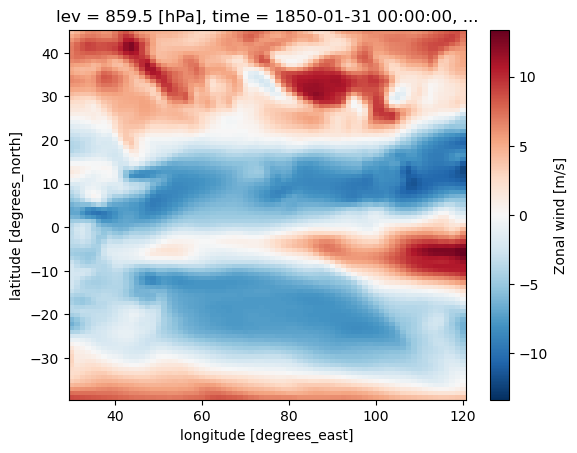

In [25]:
ds_0.U.isel(concat_dim=0).isel(time=0).plot()

  0%|          | 0/25 [00:00<?, ?it/s]

NameError: name 'units' is not defined

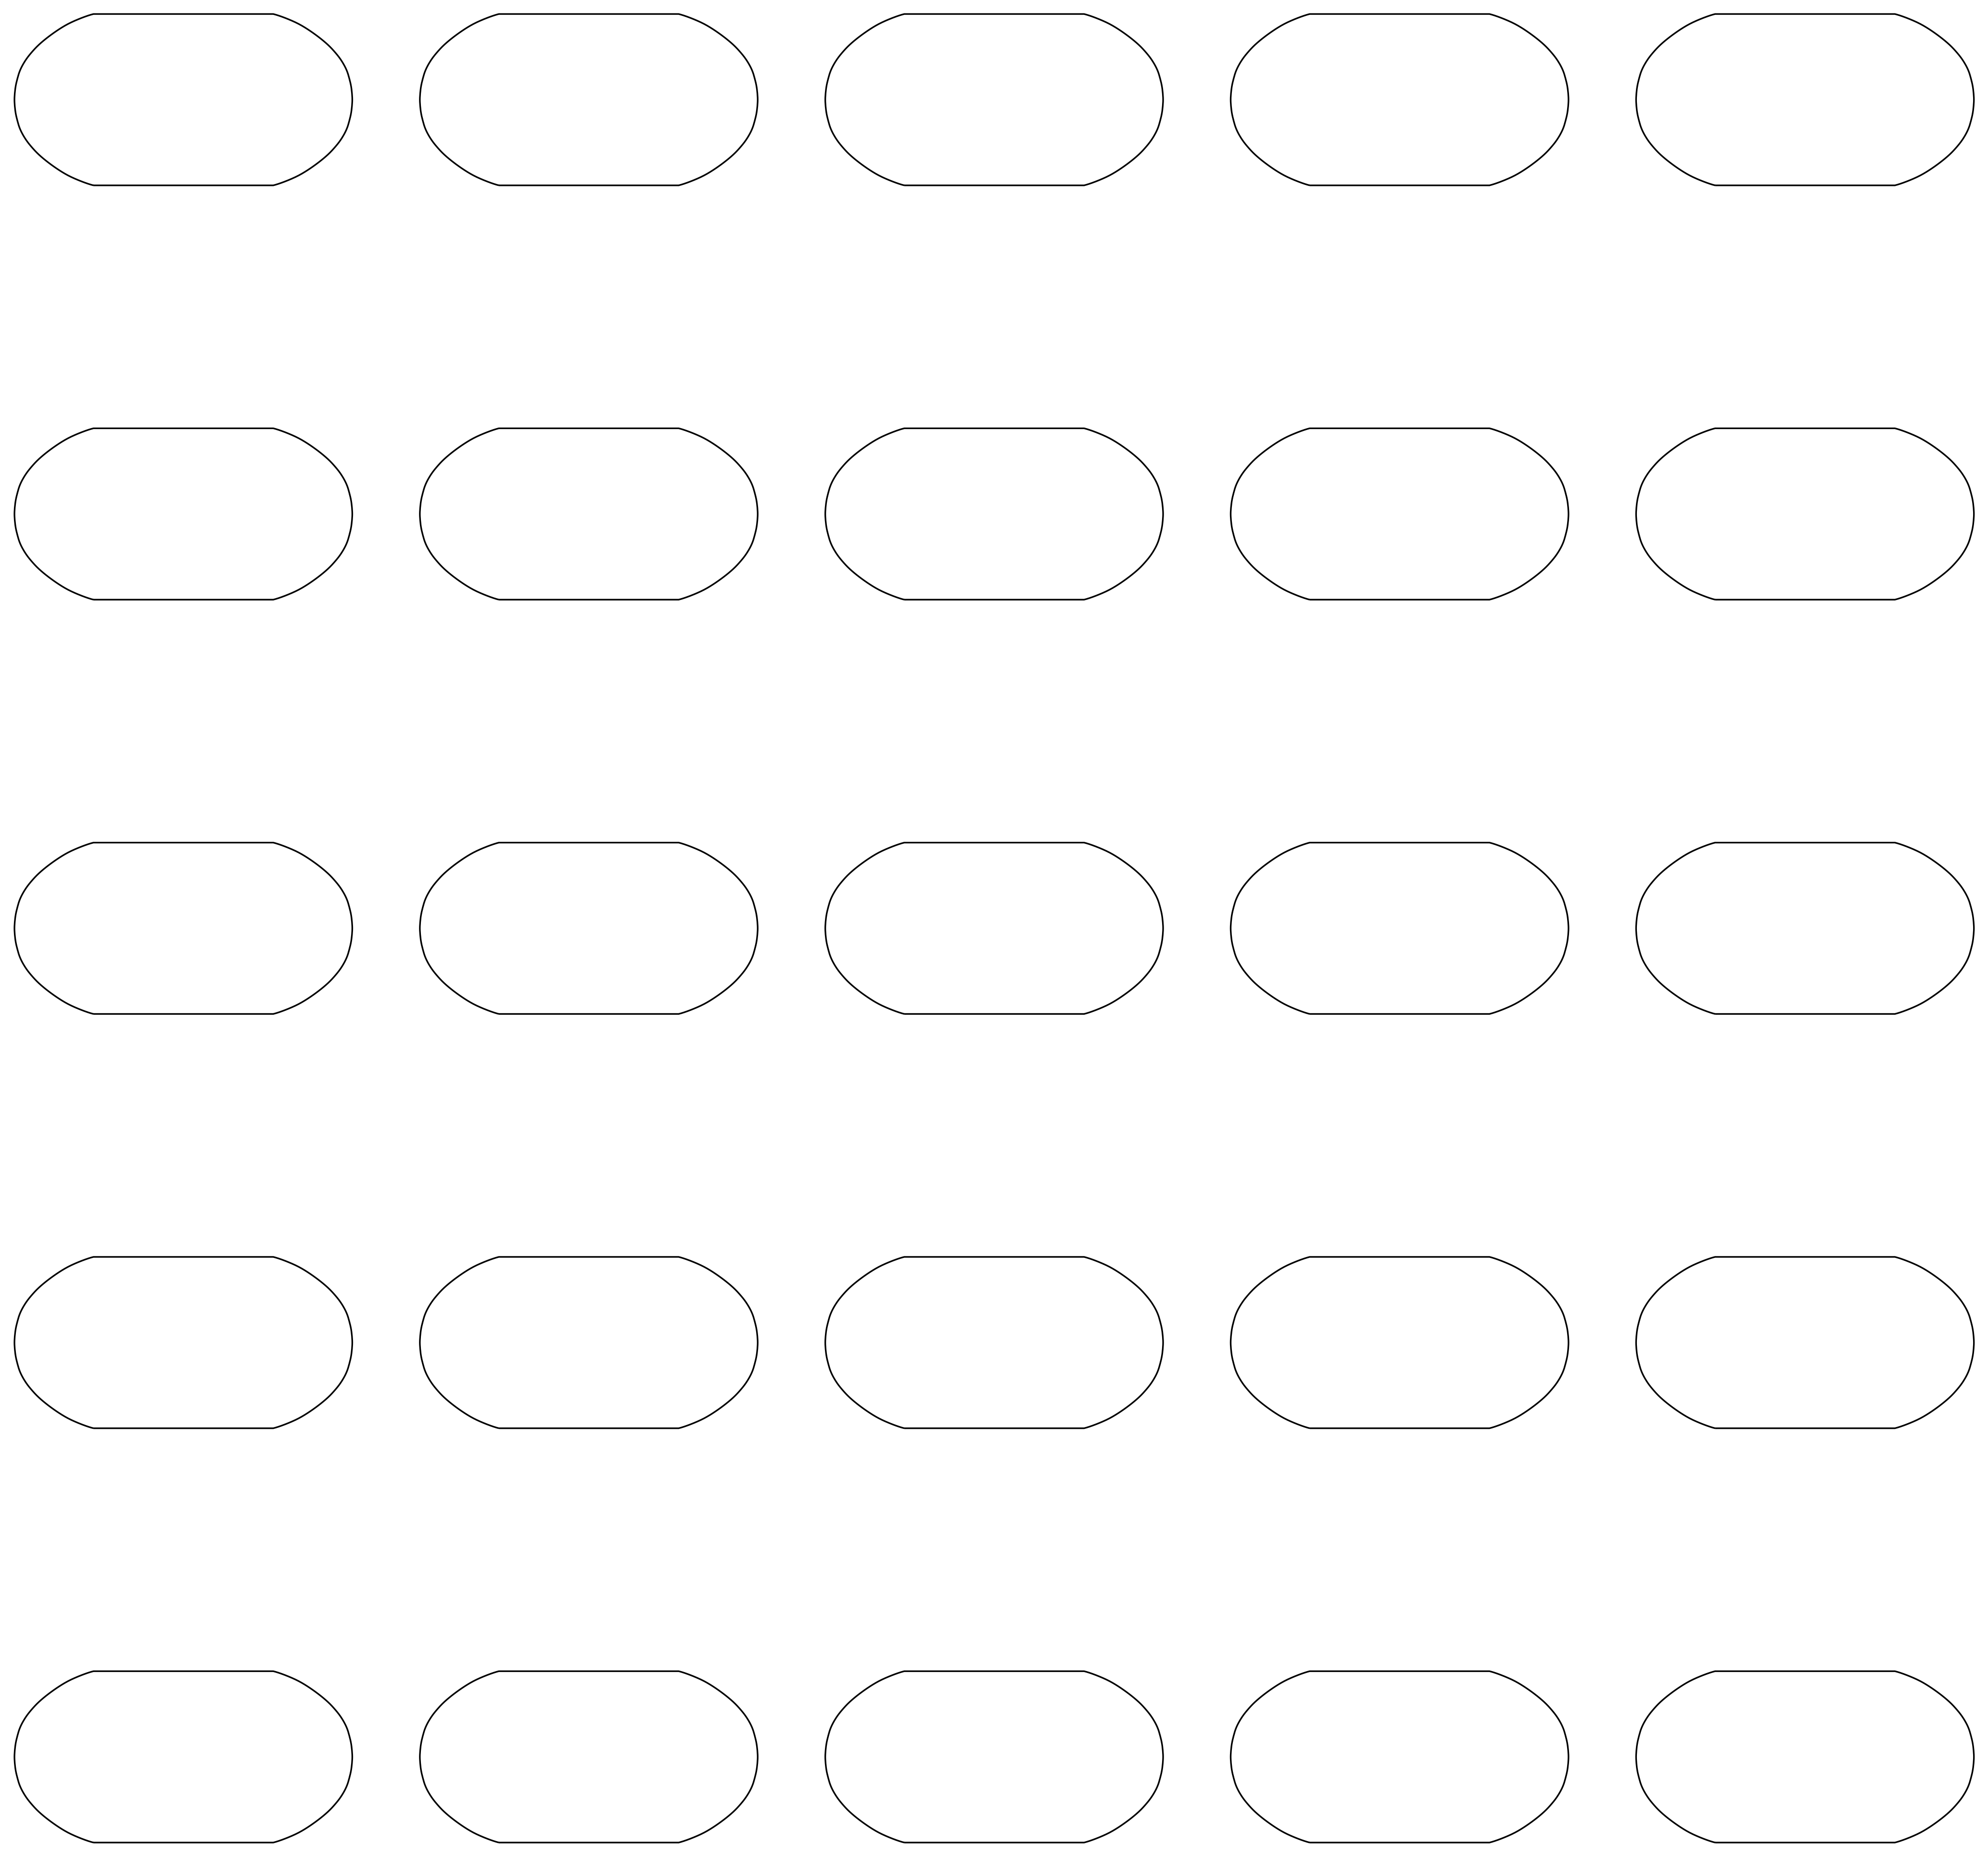

In [13]:
plt.rcParams.update({'font.size': 8})
fig,ax = plt.subplots(5,5,figsize=(17.5, 18), dpi=300, facecolor='w', edgecolor='k',subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

for i,a in enumerate(tqdm_notebook(ax.flat)) :
    clabel=('%s'%units[i])
    cbar_kwargs={'orientation':'horizontal','pad':0.01,'shrink':0.7, 'label':clabel}
    #fields[i].plot.contourf(ax=a,transform=ccrs.PlateCarree(),levels=levels[i],cbar_kwargs=cbar_kwargs,cmap=cbar[i], extend='both')
    a.add_feature(cf.LAND,color='grey')
    a.coastlines(linewidth=0.6,color='black')
    a.set_global()  


In [10]:
hyr1,hyr2=1850,2500
uvel_ts  = ds_0.U.where(ds_0.time.dt.month.isin([6,7,8,9]), drop=True).sel(time=slice(str(hyr1),str(hyr2))).groupby('time.year').mean().mean('concat_dim').squeeze().load()
vvel_ts  = ds_1.V.where(ds_1.time.dt.month.isin([6,7,8,9]), drop=True).sel(time=slice(str(hyr1),str(hyr2))).groupby('time.year').mean().mean('concat_dim').squeeze().load()
mpsl_ts  = (ds_2.PSL/100).where(ds_2.time.dt.month.isin([6,7,8,9]), drop=True).sel(time=slice(str(hyr1),str(hyr2))).groupby('time.year').mean().mean('concat_dim').squeeze().load()
prec_ts  = (ds_3.PRECT*8.64e+7).where(ds_3.time.dt.month.isin([6,7,8,9]), drop=True).sel(time=slice(str(hyr1),str(hyr2))).groupby('time.year').mean().mean('concat_dim').squeeze().load()

In [11]:
uvel_hist_clim   = uvel_ts.sel(year=slice(str(1950),str(2000))).mean('year')
uvel_nfut_clim   = uvel_ts.sel(year=slice(str(2050),str(2100))).mean('year')
uvel_efut_clim   = uvel_ts.sel(year=slice(str(2150),str(2250))).mean('year')
uvel_dfut_clim   = uvel_ts.sel(year=slice(str(2300),str(2500))).mean('year')

uvel_nfutC = uvel_nfut_clim - uvel_hist_clim
uvel_efutC = uvel_efut_clim - uvel_nfut_clim
uvel_dfutC = uvel_dfut_clim - uvel_nfut_clim
#---------------------------------------------------------------------------                                                       
vvel_hist_clim   = vvel_ts.sel(year=slice(str(1950),str(2000))).mean('year')
vvel_nfut_clim   = vvel_ts.sel(year=slice(str(2050),str(2100))).mean('year')
vvel_efut_clim   = vvel_ts.sel(year=slice(str(2150),str(2250))).mean('year')
vvel_dfut_clim   = vvel_ts.sel(year=slice(str(2300),str(2500))).mean('year')

vvel_nfutC = vvel_nfut_clim - vvel_hist_clim
vvel_efutC = vvel_efut_clim - vvel_nfut_clim
vvel_dfutC = vvel_dfut_clim - vvel_nfut_clim 
#---------------------------------------------------------------------------                                                       
mpsl_hist_clim   = mpsl_ts.sel(year=slice(str(1950),str(2000))).mean('year')
mpsl_nfut_clim   = mpsl_ts.sel(year=slice(str(2050),str(2100))).mean('year')
mpsl_efut_clim   = mpsl_ts.sel(year=slice(str(2150),str(2250))).mean('year')
mpsl_dfut_clim   = mpsl_ts.sel(year=slice(str(2300),str(2500))).mean('year')

mpsl_nfutC = mpsl_nfut_clim - mpsl_hist_clim
mpsl_efutC = mpsl_efut_clim - mpsl_nfut_clim
mpsl_dfutC = mpsl_dfut_clim - mpsl_nfut_clim 
#---------------------------------------------------------------------------                                                       
prec_hist_clim   = prec_ts.sel(year=slice(str(1950),str(2000))).mean('year')
prec_nfut_clim   = prec_ts.sel(year=slice(str(2050),str(2100))).mean('year')
prec_efut_clim   = prec_ts.sel(year=slice(str(2150),str(2250))).mean('year')
prec_dfut_clim   = prec_ts.sel(year=slice(str(2300),str(2500))).mean('year')

prec_nfutC = prec_nfut_clim - prec_hist_clim
prec_efutC = prec_efut_clim - prec_nfut_clim
prec_dfutC = prec_dfut_clim - prec_nfut_clim 

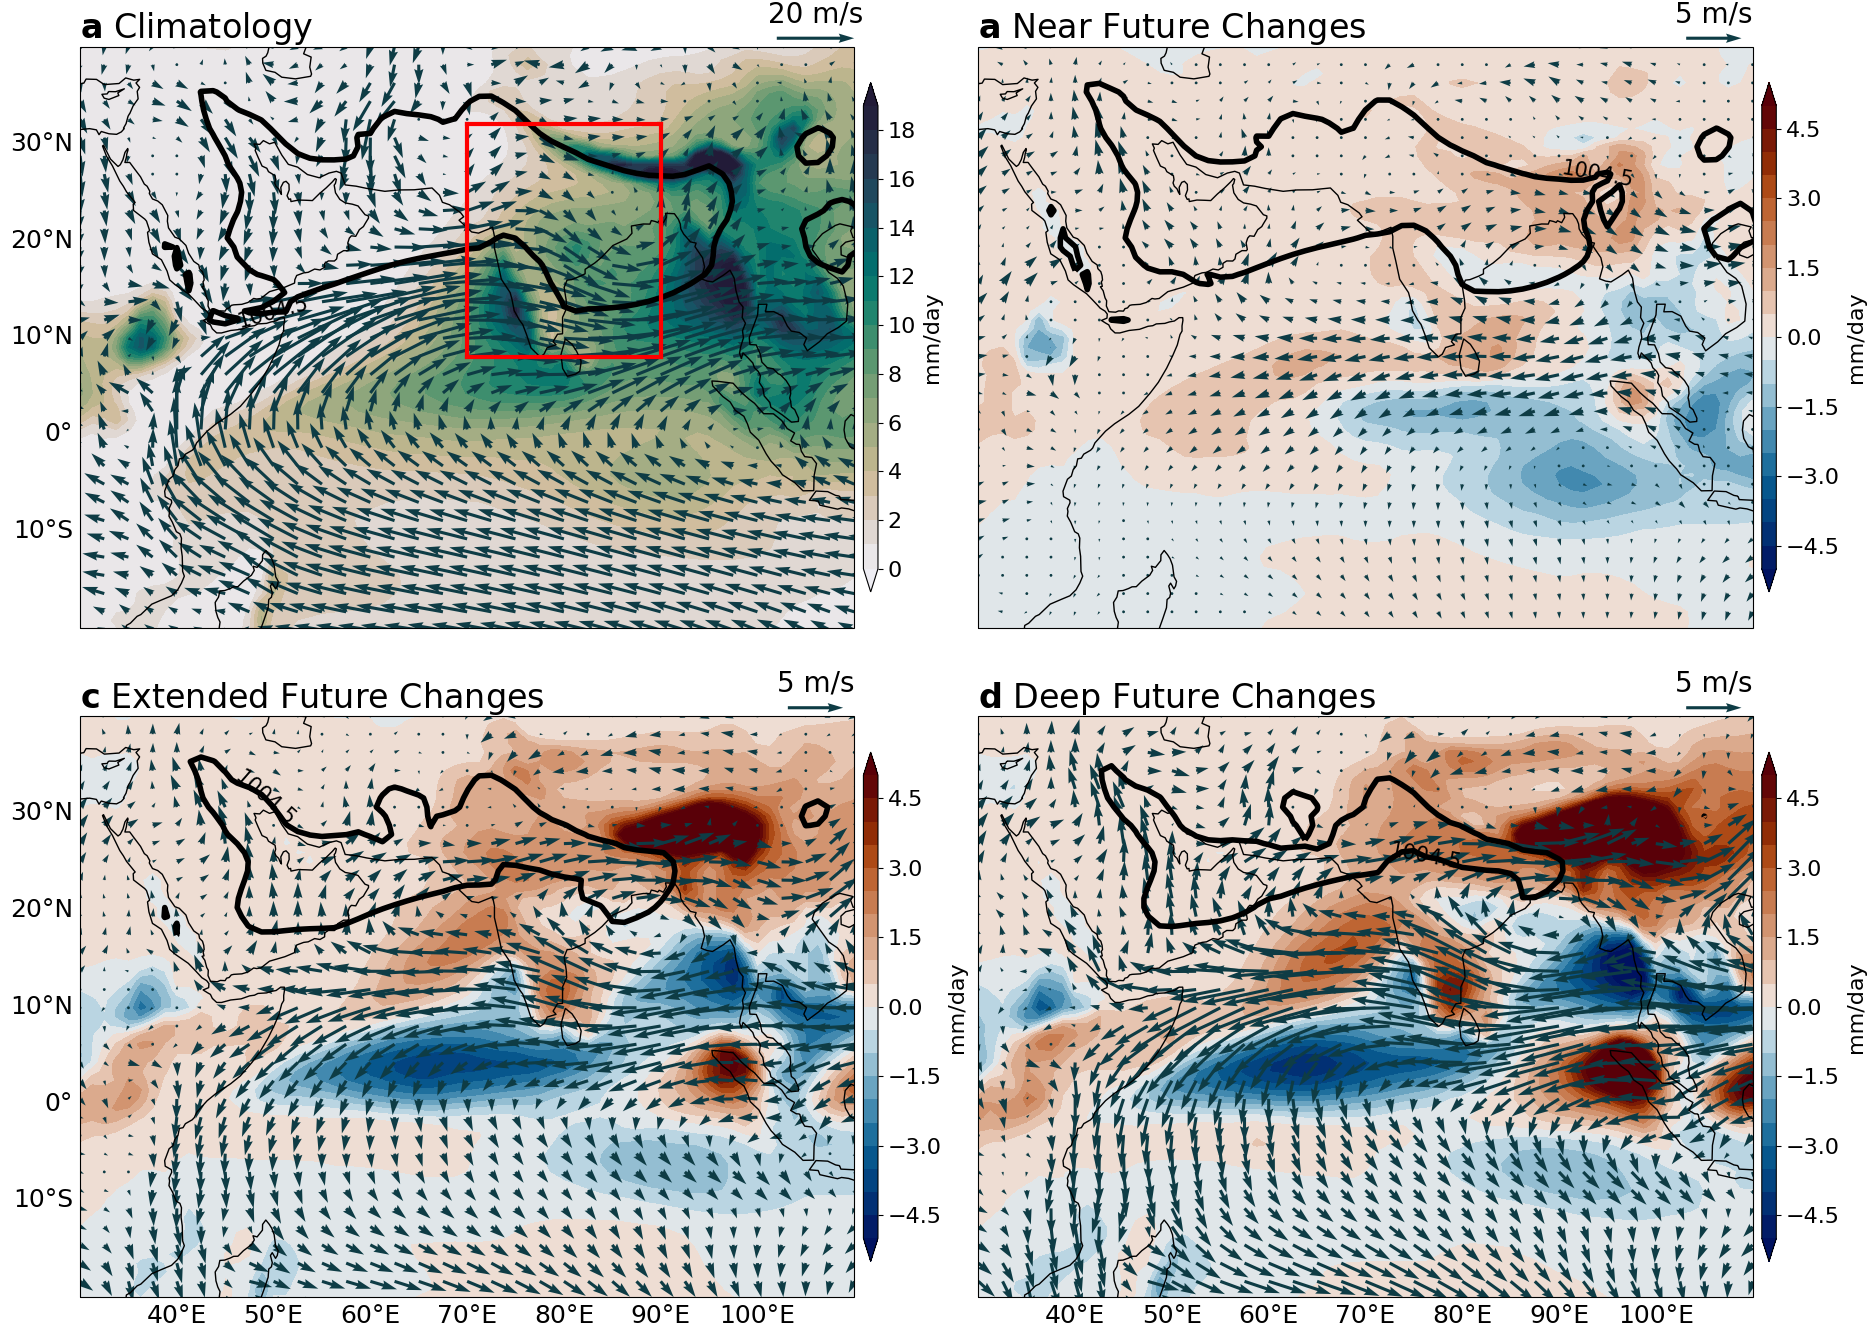

In [57]:
plt.rcParams.update({'font.size': 20})
proj=ccrs.PlateCarree(central_longitude=180)
fig=plt.figure(figsize=(30,20))
##############1st plot########################################################

ax=plt.subplot(221, projection=proj)
ax.add_feature(cfeature.LAND,linewidth=0.5, color='#d9ece7')
ax.coastlines()
ax.set_extent([30,110,-20,40], ccrs.PlateCarree()) 

plt.contourf(prec_hist_clim.lon,prec_hist_clim.lat, prec_hist_clim, levels=np.arange(0,20,1), transform=ccrs.PlateCarree(),cmap=cmocean.cm.rain, extend='both')
cb=plt.colorbar(pad=0.01, shrink=0.8, aspect= 35)
cb.set_label('mm/day',fontsize=16)
cb.ax.tick_params(labelsize=16)
p1=plt.contour(mpsl_hist_clim.lon, mpsl_hist_clim.lat, mpsl_hist_clim, levels=[1004.5], transform=ccrs.PlateCarree(), linewidths=4,colors='#000000')
plt.clabel(p1, fmt='%2.1f', colors='#000000', fontsize=15)

#plt.colorbar(pad=0.01,shrink=0.7, aspect= 35)
Q=ax.quiver(uvel_hist_clim[::2,::2].lon, uvel_hist_clim[::2,::2].lat, uvel_hist_clim[::2,::2].values, vvel_hist_clim[::2,::2].values,width=0.004,scale=200, color='#0e3c45', transform=ccrs.PlateCarree())
qk=plt.quiverkey(Q,0.95,1.015,20,'20 m/s',labelpos='N',fontproperties={'size': 20})
plt.title('$\mathbf{a}$ Climatology', loc='left')
simpledrawbox([70,8],[90,32], color='red', linewidth=3)  #box[(lon1,lat1), (lon2,lat2)]
a=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),alpha=0)
a.xlabels_top = False
a.xlabels_bottom = False
a.ylabels_left = True
a.ylabels_right = False
import matplotlib.ticker as mticker
a.ylabel_style = {'size': 18, 'color': 'black'}
a.xlabel_style = {'size': 18, 'color': 'black'}
################################################################################################################
ax=plt.subplot(222, projection=proj)
ax.add_feature(cfeature.LAND,linewidth=0.5, color='#d9ece7')
ax.coastlines()
ax.set_extent([30,110,-20,40], ccrs.PlateCarree()) 
plt.contourf(prec_nfutC.lon,prec_nfutC.lat, prec_nfutC, levels=np.arange(-5,5.5,0.5), transform=ccrs.PlateCarree(),cmap=cm.vik, extend='both')
cb=plt.colorbar(pad=0.01, shrink=0.8, aspect= 35)
cb.set_label('mm/day',fontsize=16)
cb.ax.tick_params(labelsize=16)

p1=plt.contour(mpsl_nfut_clim.lon, mpsl_nfut_clim.lat, mpsl_nfut_clim, levels=[1004.5], transform=ccrs.PlateCarree(), linewidths=4,colors='#000000')
plt.clabel(p1, fmt='%2.1f', colors='#000000', fontsize=15)

Q=ax.quiver(uvel_nfutC[::2,::2].lon, uvel_nfutC[::2,::2].lat, uvel_nfutC[::2,::2].values, vvel_nfutC[::2,::2].values,width=0.004,scale=70, color='#0e3c45', transform=ccrs.PlateCarree())
qk=plt.quiverkey(Q,0.95,1.015,5,'5 m/s',labelpos='N',fontproperties={'size': 20})
plt.title('$\mathbf{a}$ Near Future Changes', loc='left')
################################################################################################################
ax=plt.subplot(223, projection=proj)
ax.add_feature(cfeature.LAND,linewidth=0.5, color='#d9ece7')
ax.coastlines()
ax.set_extent([30,110,-20,40], ccrs.PlateCarree()) 
plt.contourf(prec_efutC.lon,prec_efutC.lat, prec_efutC, levels=np.arange(-5,5.5,0.5), transform=ccrs.PlateCarree(),cmap=cm.vik, extend='both')
cb=plt.colorbar(pad=0.01, shrink=0.8, aspect= 35)
cb.set_label('mm/day',fontsize=16)
cb.ax.tick_params(labelsize=16)

p1=plt.contour(mpsl_efut_clim.lon, mpsl_efut_clim.lat, mpsl_efut_clim, levels=[1004.5], transform=ccrs.PlateCarree(), linewidths=4,colors='#000000')
plt.clabel(p1, fmt='%2.1f', colors='#000000', fontsize=15)

Q=ax.quiver(uvel_nfutC[::2,::2].lon, uvel_nfutC[::2,::2].lat, uvel_efutC[::2,::2].values, vvel_efutC[::2,::2].values,width=0.004,scale=70, color='#0e3c45', transform=ccrs.PlateCarree())
qk=plt.quiverkey(Q,0.95,1.015,5,'5 m/s',labelpos='N',fontproperties={'size': 20})
plt.title('$\mathbf{c}$ Extended Future Changes', loc='left')
a=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),alpha=0)
a.xlabels_top = False
a.xlabels_bottom = True
a.ylabels_left = True
a.ylabels_right = False
import matplotlib.ticker as mticker
a.ylabel_style = {'size': 18, 'color': 'black'}
a.xlabel_style = {'size': 18, 'color': 'black'}
################################################################################################################
ax=plt.subplot(224, projection=proj)
ax.add_feature(cfeature.LAND,linewidth=0.5, color='#d9ece7')
ax.coastlines()
ax.set_extent([30,110,-20,40], ccrs.PlateCarree()) 
plt.contourf(prec_dfutC.lon,prec_dfutC.lat, prec_dfutC, levels=np.arange(-5,5.5,0.5), transform=ccrs.PlateCarree(),cmap=cm.vik, extend='both')
cb=plt.colorbar(pad=0.01, shrink=0.8, aspect= 35)
cb.set_label('mm/day',fontsize=16)
cb.ax.tick_params(labelsize=16)

p1=plt.contour(mpsl_dfut_clim.lon, mpsl_dfut_clim.lat, mpsl_dfut_clim, levels=[1004.5], transform=ccrs.PlateCarree(), linewidths=4,colors='#000000', linestyles='-')
plt.clabel(p1, fmt='%2.1f', colors='#000000', fontsize=15)

Q=ax.quiver(uvel_nfutC[::2,::2].lon, uvel_nfutC[::2,::2].lat, uvel_dfutC[::2,::2].values, vvel_dfutC[::2,::2].values,width=0.004,scale=70, color='#0e3c45', transform=ccrs.PlateCarree())
qk=plt.quiverkey(Q,0.95,1.015,5,'5 m/s',labelpos='N',fontproperties={'size': 20})
plt.title('$\mathbf{d}$ Deep Future Changes', loc='left')
a=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),alpha=0)
a.xlabels_top = False
a.xlabels_bottom = True
a.ylabels_left = False
a.ylabels_right = False
import matplotlib.ticker as mticker
a.ylabel_style = {'size': 18, 'color': 'black'}
a.xlabel_style = {'size': 18, 'color': 'black'}

plt.tight_layout(rect=[0.15, 0.2, 0.8, 0.9])

#plt.savefig('/proj/sahils/plots/python/ext_runs/march_onwards-2023/winds850-rainfall.png',dpi=500, bbox_inches = 'tight')

## Circulation and Rainfall changes in CMIP6

In [6]:
ds0=xr.open_mfdataset('/proj/sahils/data/cmip-ext2300/monthly/psl_mon/psl_ensmean_1850-2300_1x1.nc', chunks={'time':120},combine='nested', parallel='True', decode_times=False)
ds1=xr.open_mfdataset('/proj/sahils/data/cmip-ext2300/pr_2300_mon/pr_ensemble_1850-2300.nc1', chunks={'time':120},combine='nested', parallel='True', decode_times=False)


In [41]:
ds3=xr.open_mfdataset('/proj/sahils/data/cmip-ext2300/monthly/ua_mon/ua_Amon_ensmean_1850-2300_1x1_850hpa.nc', chunks={'time':120},combine='nested', parallel='True', decode_times=False)
ds4=xr.open_mfdataset('/proj/sahils/data/cmip-ext2300/monthly/va_mon/va_Amon_ensmean_1850-2300_850hpa_1x1.nc', chunks={'time':120},combine='nested', parallel='True', decode_times=False)

In [42]:
time_new=xr.cftime_range(start='1850',end='2300',freq='1M',calendar='noleap')
ds0   =ds0.assign_coords(time=time_new)
ds1   =ds1.assign_coords(time=time_new)
ds3   =ds3.assign_coords(time=time_new)
ds4   =ds4.assign_coords(time=time_new)

In [13]:
hyr1,hyr2=1850,2300

mpsl_ts_cmip  = (ds0.psl/100).where(ds0.time.dt.month.isin([6,7,8,9]), drop=True).sel(time=slice(str(hyr1),str(hyr2))).groupby('time.year').mean().squeeze().load()
prec_ts_cmip  = (ds1.pr*86400).where(ds1.time.dt.month.isin([6,7,8,9]), drop=True).sel(time=slice(str(hyr1),str(hyr2))).groupby('time.year').mean().squeeze().load()

In [43]:
ua_ts_cmip  = ds3.ua.where(ds3.time.dt.month.isin([6,7,8,9]), drop=True).sel(time=slice(str(hyr1),str(hyr2))).groupby('time.year').mean().squeeze().load()
va_ts_cmip  = ds4.va.where(ds4.time.dt.month.isin([6,7,8,9]), drop=True).sel(time=slice(str(hyr1),str(hyr2))).groupby('time.year').mean().squeeze().load()

In [49]:
#---------------------------------------------------------------------------                                                       
mpsl_cmip_hist_clim   = mpsl_ts_cmip.sel(year=slice(str(1950),str(2000))).mean('year')
mpsl_cmip_nfut_clim   = mpsl_ts_cmip.sel(year=slice(str(2050),str(2100))).mean('year')
mpsl_cmip_efut_clim   = mpsl_ts_cmip.sel(year=slice(str(2150),str(2250))).mean('year')
mpsl_cmip_nfutC = mpsl_cmip_nfut_clim - mpsl_cmip_hist_clim
mpsl_cmip_efutC = mpsl_cmip_efut_clim - mpsl_cmip_nfut_clim
#---------------------------------------------------------------------------                                                       
prec_cmip_hist_clim   = prec_ts_cmip.sel(year=slice(str(1950),str(2000))).mean('year')
prec_cmip_nfut_clim   = prec_ts_cmip.sel(year=slice(str(2050),str(2100))).mean('year')
prec_cmip_efut_clim   = prec_ts_cmip.sel(year=slice(str(2150),str(2250))).mean('year')
prec_cmip_nfutC = prec_cmip_nfut_clim - prec_cmip_hist_clim
prec_cmip_efutC = prec_cmip_efut_clim - prec_cmip_nfut_clim
#---------------------------------------------------------------------------                                                       
ua_cmip_hist_clim   = ua_ts_cmip.sel(year=slice(str(1950),str(2000))).mean('year')
ua_cmip_nfut_clim   = ua_ts_cmip.sel(year=slice(str(2050),str(2100))).mean('year')
ua_cmip_efut_clim   = ua_ts_cmip.sel(year=slice(str(2150),str(2250))).mean('year')
ua_cmip_nfutC = ua_cmip_nfut_clim - ua_cmip_hist_clim
ua_cmip_efutC = ua_cmip_efut_clim - ua_cmip_nfut_clim
#---------------------------------------------------------------------------                                                       
va_cmip_hist_clim   = va_ts_cmip.sel(year=slice(str(1950),str(2000))).mean('year')
va_cmip_nfut_clim   = va_ts_cmip.sel(year=slice(str(2050),str(2100))).mean('year')
va_cmip_efut_clim   = va_ts_cmip.sel(year=slice(str(2150),str(2250))).mean('year')
va_cmip_nfutC = va_cmip_nfut_clim - va_cmip_hist_clim
va_cmip_efutC = va_cmip_efut_clim - va_cmip_nfut_clim

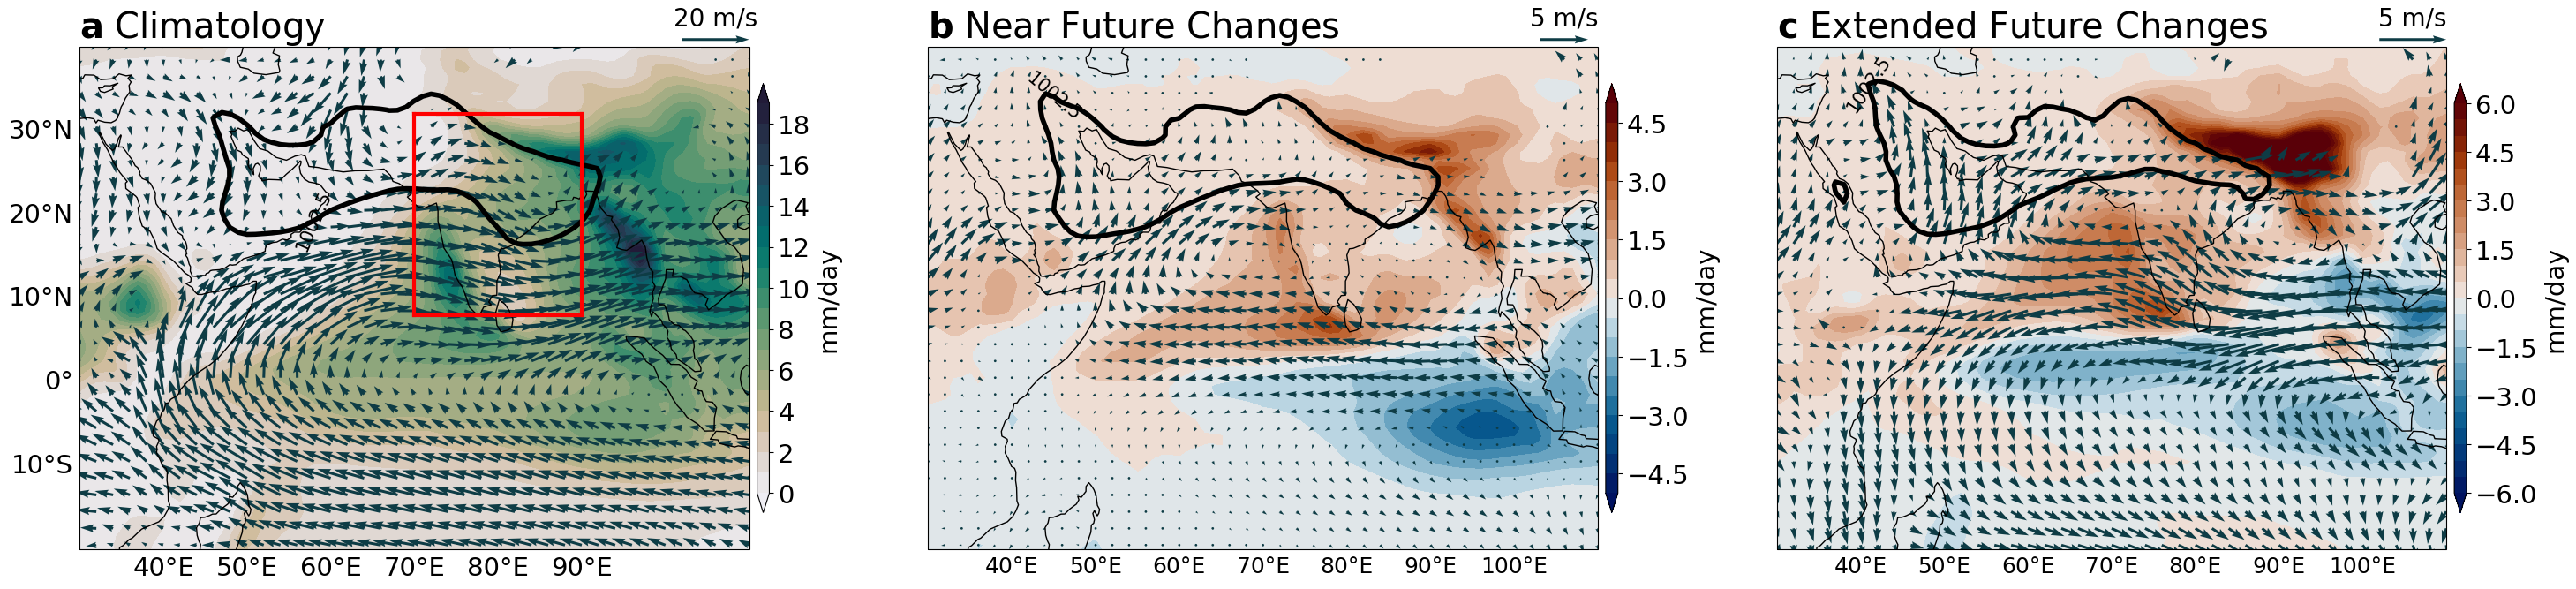

In [65]:
plt.rcParams.update({'font.size': 24})
proj=ccrs.PlateCarree(central_longitude=180)
fig=plt.figure(figsize=(30,25))
##############1st plot########################################################

ax=plt.subplot(131, projection=proj)
ax.add_feature(cfeature.LAND,linewidth=0.5, color='#d9ece7')
ax.coastlines()
ax.set_extent([30,110,-20,40], ccrs.PlateCarree()) 

plt.contourf(prec_cmip_hist_clim.lon, prec_cmip_hist_clim.lat, prec_cmip_hist_clim, levels=np.arange(0,20,1), transform=ccrs.PlateCarree(),cmap=cmocean.cm.rain, extend='both')
cb=plt.colorbar(pad=0.01, shrink=0.2, aspect= 35)
cb.set_label('mm/day',fontsize=21)
cb.ax.tick_params(labelsize=21)
p1=plt.contour(mpsl_cmip_hist_clim.lon, mpsl_cmip_hist_clim.lat, mpsl_cmip_hist_clim, levels=[1002.5], transform=ccrs.PlateCarree(), linewidths=4,colors='#000000')
plt.clabel(p1, fmt='%2.1f', colors='#000000', fontsize=15)

#plt.colorbar(pad=0.01,shrink=0.7, aspect= 35)
Q=ax.quiver(ua_cmip_hist_clim[::2,::2].lon, ua_cmip_hist_clim[::2,::2].lat, ua_cmip_hist_clim[::2,::2].values, va_cmip_hist_clim[::2,::2].values,width=0.004,scale=200, color='#0e3c45', transform=ccrs.PlateCarree())
qk=plt.quiverkey(Q,0.95,1.015,20,'20 m/s',labelpos='N',fontproperties={'size': 20})

plt.title('$\mathbf{a}$ Climatology', loc='left')

simpledrawbox([70,8],[90,32], color='red', linewidth=3)  #box[(lon1,lat1), (lon2,lat2)]
a=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),alpha=0)
a.xlabels_top = False
a.xlabels_bottom = True
a.ylabels_left = True
a.ylabels_right = False
import matplotlib.ticker as mticker
a.ylabel_style = {'size': 21, 'color': 'black'}
a.xlabel_style = {'size': 21, 'color': 'black'}

################################################################################################################
ax=plt.subplot(132, projection=proj)
ax.add_feature(cfeature.LAND,linewidth=0.5, color='#d9ece7')
ax.coastlines()
ax.set_extent([30,110,-20,40], ccrs.PlateCarree()) 
plt.contourf(prec_cmip_nfutC.lon,prec_cmip_nfutC.lat, prec_cmip_nfutC, levels=np.arange(-5,5.5,0.5), transform=ccrs.PlateCarree(),cmap=cm.vik, extend='both')
cb=plt.colorbar(pad=0.01, shrink=0.2, aspect= 35)
cb.set_label('mm/day',fontsize=21)
cb.ax.tick_params(labelsize=21)

p1=plt.contour(mpsl_cmip_nfut_clim.lon, mpsl_cmip_nfut_clim.lat, mpsl_cmip_nfut_clim, levels=[1002.5], transform=ccrs.PlateCarree(), linewidths=4,colors='#000000')
plt.clabel(p1, fmt='%2.1f', colors='#000000', fontsize=15)

Q=ax.quiver(ua_cmip_nfutC[::2,::2].lon, ua_cmip_nfutC[::2,::2].lat, ua_cmip_nfutC[::2,::2].values, va_cmip_nfutC[::2,::2].values,width=0.004,scale=70, color='#0e3c45', transform=ccrs.PlateCarree())
qk=plt.quiverkey(Q,0.95,1.015,5,'5 m/s',labelpos='N',fontproperties={'size': 20})
plt.title('$\mathbf{b}$ Near Future Changes', loc='left')

a=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),alpha=0)
a.xlabels_top = False
a.xlabels_bottom = True
a.ylabels_left = False
a.ylabels_right = False
import matplotlib.ticker as mticker
a.ylabel_style = {'size': 18, 'color': 'black'}
a.xlabel_style = {'size': 18, 'color': 'black'}

################################################################################################################
ax=plt.subplot(133, projection=proj)
ax.add_feature(cfeature.LAND,linewidth=0.5, color='#d9ece7')
ax.coastlines()
ax.set_extent([30,110,-20,40], ccrs.PlateCarree()) 
plt.contourf(prec_cmip_efutC.lon,prec_cmip_efutC.lat, prec_cmip_efutC, levels=np.arange(-6,6.5,0.5), transform=ccrs.PlateCarree(),cmap=cm.vik, extend='both')
cb=plt.colorbar(pad=0.01, shrink=0.2, aspect= 35)
cb.set_label('mm/day',fontsize=21)
cb.ax.tick_params(labelsize=21)

p1=plt.contour(mpsl_cmip_efut_clim.lon, mpsl_cmip_efut_clim.lat, mpsl_cmip_efut_clim, levels=[1002.5], transform=ccrs.PlateCarree(), linewidths=4,colors='#000000')
plt.clabel(p1, fmt='%2.1f', colors='#000000', fontsize=15)

Q=ax.quiver(ua_cmip_efutC[::2,::2].lon, ua_cmip_efutC[::2,::2].lat, ua_cmip_efutC[::2,::2].values, va_cmip_efutC[::2,::2].values,width=0.004,scale=50, color='#0e3c45', transform=ccrs.PlateCarree())
qk=plt.quiverkey(Q,0.95,1.015,5,'5 m/s',labelpos='N',fontproperties={'size': 20})
plt.title('$\mathbf{c}$ Extended Future Changes', loc='left')
a=ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),alpha=0)
a.xlabels_top = False
a.xlabels_bottom = True
a.ylabels_left = False
a.ylabels_right = False
import matplotlib.ticker as mticker
a.ylabel_style = {'size': 18, 'color': 'black'}
a.xlabel_style = {'size': 18, 'color': 'black'}
plt.tight_layout()